# Lab-09: DBpedia14 classification with BERT

In Lab-03 we used linear text classification models (the perceptron, linear SVM, multinomial naive Bayes, softmax regression) on the DBpedia14 dataset. Recall that our best test accuracy was in the 92-93% range. Here we will use the BERT transformer model pretrained on vast amounts of text data to achieve ~99% test accuracy with minimal hyperparameter tuning.

### Class labels

In [1]:
!pip install datasets

     |████████████████████████████████| 290 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 40.6 MB/s 
     |████████████████████████████████| 132 kB 46.6 MB/s 
     |████████████████████████████████| 243 kB 52.5 MB/s 
     |████████████████████████████████| 59 kB 6.8 MB/s 
     |████████████████████████████████| 271 kB 48.6 MB/s 
     |████████████████████████████████| 192 kB 47.7 MB/s 
     |████████████████████████████████| 160 kB 46.5 MB/s 


In [2]:
labels = {
    0: "Company",
    1: "EducationalInstitution",
    2: "Artist",
    3: "Athlete",
    4: "OfficeHolder",
    5: "MeanOfTransportation",
    6: "Building",
    7: "NaturalPlace",
    8: "Village",
    9: "Animal",
    10: "Plant",
    11: "Album",
    12: "Film",
    13: "WrittenWork"
}

K = len(labels)

## Download the dataset

In [3]:
# Colab provides limited GPU time (be mindful when increasing this number)
M = 30000

In [4]:
import datasets
import pandas as pd

df_train, df_test = datasets.load_dataset(
    'dbpedia_14', 
    split=['train[:80%]', 
           'test[80%:]']
)

df_train = df_train.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.8 * M)]
df_test = df_test.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.2 * M)]

Downloading:   0%|          | 0.00/2.14k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/68.3M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset d_bpedia14 downloaded and prepared to /root/.cache/huggingface/datasets/d_bpedia14/dbpedia_14/2.0.0/7f0577ea0f4397b6b89bfe5c5f2c6b1b420990a1fc5e8538c7ab4ec40e46fa3e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## (5 pts) Task 1: Analyze the data

a. What is the distribution of the labels in this data? *Hint*: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html

b. Compute the distribution of sentence length in the dataset

c. Are there any differences between the train and test sets? If so make any necessary changes to the train/test sets such that they look the same.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f1590df50>]],
      dtype=object)

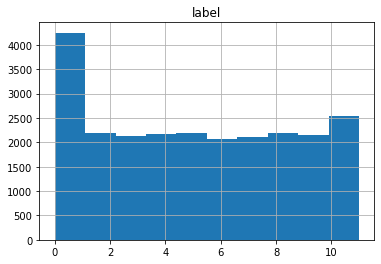

In [5]:
# Your code goes here
df_train.hist()

In [6]:
df_train.head()

,label,title,content
0,3,Tatyana Titova,Tatyana Titova (Russian: Татьяна Титова) (bor...
1,9,Sunfire (horse),Sunfire (foaled 1925 in Kentucky) was an Amer...
2,4,James Hope 1st Baron Rankeillour,James Fitzalan Hope 1st Baron Rankeillour PC ...
3,3,Barry Butlin,Barry Desmond Butlin (born 9 November 1949 in...
4,10,Olneya,Olneya tesota is a perennial flowering tree o...


In [7]:
sentence_lengths = []
for row in df_train.iterrows():
  sentences = row[1]['content'].split('.')
  for sent in sentences:
    sentence_lengths.append(len(sent.split()))

In [8]:
import seaborn as sns

In [9]:
sns.set()

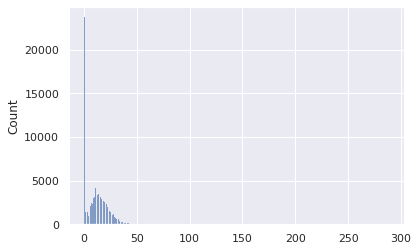

In [10]:
sns.histplot(sentence_lengths)

In [11]:
import numpy as np
sentence_lengths = np.array(sentence_lengths)
np.mean(sentence_lengths)

11.65793565739982

In [12]:
np.std(sentence_lengths)

10.35459809395533

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7eecf025d0>]],
      dtype=object)

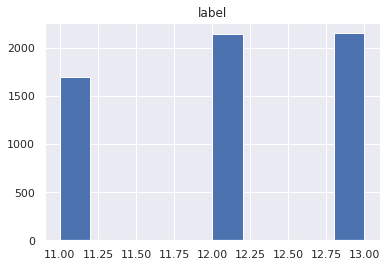

In [13]:
df_test.hist()

In [14]:
df_test.head()

,label,title,content
0,13,Nemoe Karma,Nemoe Karma (Finding a Soulmate) is a 1931 no...
1,13,Livingston County Daily Press & Argus,The Livingston County Daily Press & Argus is ...
2,12,Night of Terror,Night of Terror is a 1933 horror film directe...
3,12,La settimana della Sfinge,La settimana della Sfinge (internationally re...
4,11,Just Visiting (album series),Just Visiting is a two-part 2002 Cog EP serie...


In [15]:
sentence_lengths = []
for row in df_train.iterrows():
  sentences = row[1]['content'].split('.')
  for sent in sentences:
    sentence_lengths.append(len(sent.split()))

sentence_lengths = np.array(sentence_lengths)
np.mean(sentence_lengths)

11.65793565739982

In [16]:
np.std(sentence_lengths)

10.35459809395533

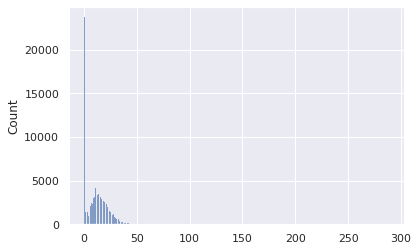

In [17]:
sns.histplot(sentence_lengths)

In [18]:
# Datasets look pretty similar with regards to distributions!
# The label distributions are very different though...

## (10 pts) Task 2: Train BERT on DBpedia14 using the provided code

Here you just need to run the cells below on a GPU. To do this we are going to use Google CoLab, which provides free (but limited) use of hosted GPU instances.

Before doing this, take a look at the leaderboard for DBpedia14: https://paperswithcode.com/dataset/dbpedia. You'll find various transformers (including BERT) at the top. Here we will use a smaller version of BERT called DistilBERT which reduces the computational overhead with only marginal performance degradation, and only two training epochs over an abridged version of the dataset.

How does DistilBERT perform relative to the linear text classifiers from Lab 03?

### Google CoLab

To complete tasks 2 & 3, you will need to login to a Google account and then go here: https://colab.research.google.com. Then do the following:

1. End any existing CoLab sessions that you have running

2. Click on the `Upload` tab and upload this file

3. Click on `Runtime -> Change runtime type` and select `GPU`

### Install packages

In [19]:
!pip install -q transformers torch

     |████████████████████████████████| 3.1 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 41.5 MB/s 
     |████████████████████████████████| 3.3 MB 35.0 MB/s 
     |████████████████████████████████| 895 kB 44.9 MB/s 


### Restart runtime

After running the cell above, click `Runtime -> Restart runtime`. This only needs to be done one time per session.

### Hyperparameters

In [20]:
batch_size = 32
epochs = 2
lr_init = 1e-5
max_len = 256
warmup_steps = 3

### Create batched inputs using Huggingface's DistilBERT tokenizer 

In [21]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

def batch_data(data, bsize):
    batches = []
    sentences = data['content'].tolist()
    labels = data['label'].tolist()
    for i in range(0, len(sentences), bsize):
        s = sentences[i: i + bsize]
        Y = labels[i: i + bsize]
        X = tokenizer.batch_encode_plus(
            s, max_length=max_len, padding='longest', truncation=True,
            return_attention_mask=True, return_token_type_ids=False)
        batches.append((X, Y, s))
    return batches

train_batches = batch_data(df_train, bsize=batch_size)
test_batches = batch_data(df_test, bsize=batch_size)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

### Load pretrained Distilbert model

This cell uses the `DistilBertForSequenceClassification` class, which is a convenience wrapper that places a classification head onto the DistilBert language model. 

In [22]:
from tqdm import tqdm
import torch
from transformers import DistilBertForSequenceClassification, \
  AdamW, get_linear_schedule_with_warmup


model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=K, 
    output_hidden_states=True)

if torch.cuda.is_available():
    device = torch.device('cuda:0') # GPU
else:
    device = torch.device('cpu') # CPU
model.to(device)

optimizer = AdamW(model.parameters(), lr=lr_init)
lr = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, 
    num_training_steps=len(train_batches))

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.wei

### Training loop

*Note: This should take about 20 minutes on CoLabs K80 GPUs*

In [23]:
from datasets import load_metric

def runner(batches, desc: str, train=True):
    
    grad_mode = torch.enable_grad if train else torch.no_grad
    preds = []
    
    if train:
        model.train()
    else:
        model.eval()
    
    for epoch in range(epochs if train else 1):
        
        acc = load_metric("accuracy", keep_in_memory=True)
        f1 = load_metric("f1", keep_in_memory=True)
        cumloss = 0.0
        embeds = []
        
        with tqdm(total=len(batches)) as bar:

            for i, batch in enumerate(batches):
                X, Y, _ = batch
                inputs = torch.tensor(X['input_ids'], device=device)
                attmsk = torch.tensor(X['attention_mask'], device=device)
                labels = torch.tensor(Y, device=device)
                batch = {'input_ids': inputs,
                         'attention_mask': attmsk,
                         'labels': labels}
                with grad_mode():
                    outputs = model(**batch)
                    embeds.append(outputs[-1][1][:, 0, :].squeeze().detach().cpu())
                    loss = outputs.loss
                    if train:
                        loss.backward()
                        optimizer.step()
                        lr.step()
                        optimizer.zero_grad()
                    logits = outputs.logits
                    Yhat = torch.argmax(logits, dim=-1)
                    preds.append(Yhat)
                    cumloss += loss.clone().detach().cpu().item()
                    acc.add_batch(predictions=Yhat, references=Y)
                    f1.add_batch(predictions=Yhat, references=Y)

                bar.update(1)
            bar.set_description('epoch: %s, %s loss: %.5f, f1-score: %.5f, accuracy: %.5f' %
                                (epoch + 1, desc,
                                 cumloss / (i + 1),
                                 f1.compute(average="macro")['f1'],
                                 acc.compute()['accuracy']))
                
    embeds = torch.cat(embeds, dim=0)
        
    return preds, embeds

In [24]:
# Train model
runner(train_batches, 'train');

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

epoch: 1, train loss: 0.42162, f1-score: 0.86606, accuracy: 0.93904: 100%|██████████| 750/750 [08:32<00:00,  1.46it/s]
epoch: 2, train loss: 0.08935, f1-score: 0.99041, accuracy: 0.99000: 100%|██████████| 750/750 [08:34<00:00,  1.46it/s]


### Model evaluation

In [25]:
# Evaluate training set
preds_train, embeds_train = runner(train_batches, 'train', train=False);

epoch: 1, train loss: 0.07270, f1-score: 0.99095, accuracy: 0.99050: 100%|██████████| 750/750 [03:12<00:00,  3.89it/s]


In [26]:
# Evaluate test set
preds_test, embeds_test = runner(test_batches, 'test', train=False);

epoch: 1, test loss: 3.20936, f1-score: 0.05512, accuracy: 0.28300: 100%|██████████| 188/188 [00:45<00:00,  4.13it/s]


In [27]:
# Your code goes here
print("Mean Training Accuracy:")
accuracies = []
for i in range(len(train_batches)):
  accuracy = sum([train_batches[i][1][j] == preds_train[i][j] for j in range(len(train_batches[i][1]))]) / len(train_batches[i][1])
  accuracies.append(accuracy)
accuracies = np.array(accuracies)
print(sum(accuracies) / accuracies.shape[0])

print("Mean Testing Accuracy:")
accuracies = []
for i in range(len(test_batches)):
  accuracy = sum([test_batches[i][1][j] == preds_test[i][j] for j in range(len(test_batches[i][1]))]) / len(test_batches[i][1])
  accuracies.append(accuracy)
accuracies = np.array(accuracies)
print(sum(accuracies) / accuracies.shape[0])

Mean Training Accuracy:
tensor(0.9905, device='cuda:0')
Mean Testing Accuracy:
tensor(0.2832, device='cuda:0')


## (5 pts) Task 3: test your model on new string

Make up (or find) a document that maps to one of the 14 classes in DBpedia14. Is the model's prediction in agreement with your label assignment? The cell below contains some helper code to get you started. To compute the model prediction, reuse the `batch_data()` and `runner()` functions.

### Starter code

In [28]:
import numpy as np
import pandas as pd

example_text = """Her is a 2013 American science-fiction romantic drama film written, 
directed, and produced by Spike Jonze. It marks Jonze's solo screenwriting debut. 
The film follows Theodore Twombly (Joaquin Phoenix), a man who develops a relationship 
with Samantha (Scarlett Johansson), an artificially intelligent virtual assistant 
personified through a female voice."""

example_label = 12 # "film"

df = pd.DataFrame({'content': [example_text], 'label': example_label, 'title': None})

In [29]:
# Your code goes here
example_batch = batch_data(df, 1)

In [30]:
preds, embeds = runner(example_batch, 'test', train=False)
preds[0] == example_label

epoch: 1, test loss: 4.16142, f1-score: 0.00000, accuracy: 0.00000: 100%|██████████| 1/1 [00:00<00:00, 31.80it/s]


tensor([False], device='cuda:0')

## (5 pts extra credit) Task 4: Extract the document embeddings and visualize them in Tensorboard Projector

### TSV helper functions from Lecture 05

In [31]:
def save_matrix(matrix, fpath):
    D1, D2 = matrix.shape
    tsv = ""
    for i in range(D1):
        for j in range(D2):
            tsv += str(matrix[i, j]) + '\t'
        tsv = tsv.strip('\t') + '\n'
    tsv = tsv.strip('\n')
    with open(fpath, "w") as fd:
        fd.write(tsv)

def save_docs(docs, labels, fpath):
    tsv = "document\tlabel\n"
    for doc, label in zip(docs, labels):
        tsv += doc.lower().strip() + '\t' + label + '\n'
    tsv = tsv.strip('\n')
    with open(fpath, "w") as fd:
        fd.write(tsv)

### Extract embeddings

In [38]:
# Your code goes here
save_matrix(embeds_train, "train_embeddings.tsv")

In [39]:
save_matrix(embeds_test, "test_embeddings.tsv")

### Visualize embeddings

The embeddings and text can be saved in tsv format and uploaded here  https://projector.tensorflow.org/ for visualization. Choose the tSNE algorithm.

In [ ]:
# Your code goes here